In [ ]:
# 📦 Imports and Configuration

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

sns.set(style="whitegrid")

In [ ]:
# 📁 src/setup_paths.py
# ➤ Initialization of DATA_PATH, SAVE_ROOT, and result directories

#DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_interference_base.csv"
#SAVE_ROOT = "/kaggle/working"

DATA_PATH = "/mnt/d/projects/wind_pressure_prediction_2025/data/processed/windloading_interference_base.csv"
SAVE_ROOT = "/mnt/d/projects/wind_pressure_prediction_2025"

LOG_DIR = os.path.join(SAVE_ROOT, "results", "logs")
WEIGHTS_DIR = os.path.join(SAVE_ROOT, "models", "weights")
CONFIG_DIR = os.path.join(SAVE_ROOT, "models", "configs")
METRICS_DIR = os.path.join(SAVE_ROOT, "results", "metrics")
FIGURES_DIR = os.path.join(SAVE_ROOT, "results", "figures")

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(WEIGHTS_DIR, exist_ok=True)
os.makedirs(CONFIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [ ]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [ ]:
# 📁 src/metrics/regression_metrics.py
# ➤ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}

In [ ]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# 📁 src/visualization/plot_metrics.py
# ➤ Visualization of prediction results and training loss

def plot_metrics(y_true, y_pred, train_loss_history, val_loss_history, model_name: str, save_dir=FIGURES_DIR, show=False):

    if hasattr(y_true, "detach"):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, "detach"):
        y_pred = y_pred.detach().cpu().numpy()

    epochs = np.arange(1, len(train_loss_history) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
    # 1. Scatter
    axes[0].scatter(y_true, y_pred, alpha=0.5, color='royalblue')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[0].set_title("Predicted vs True, Cp")
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")

    # 2. Residuals Histogram
    errors = (y_pred - y_true).flatten() 
    sns.histplot(errors, bins=50, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title("Prediction Error Distribution, Cp")
    axes[1].set_xlabel("Error")
    axes[1].set_ylabel("Count")

    # 3. Train loss
    axes[2].plot(epochs, train_loss_history, label='Train Loss', color='green')
    axes[2].set_title("Training Loss, Cp")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].legend()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{model_name}_metrics.png")
    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

    print(f"📊 Metric saved: {save_path}")
    return save_path


Dataset loaded: 151392 rows, 15 columns
🖥 Используемое устройство: cpu
Number of matching rows: 0


Epochs:   2%|▏         | 12/500 [00:01<00:44, 10.92it/s]

Epoch [10/500], Loss: 12.0590


Epochs:   4%|▍         | 22/500 [00:02<00:42, 11.38it/s]

Epoch [20/500], Loss: 2.7142


Epochs:   6%|▋         | 32/500 [00:03<00:40, 11.57it/s]

Epoch [30/500], Loss: 0.3660


Epochs:   8%|▊         | 42/500 [00:03<00:40, 11.28it/s]

Epoch [40/500], Loss: 0.9461


Epochs:  10%|█         | 52/500 [00:04<00:40, 11.05it/s]

Epoch [50/500], Loss: 0.3339


Epochs:  12%|█▏        | 62/500 [00:05<00:41, 10.68it/s]

Epoch [60/500], Loss: 0.2306


Epochs:  14%|█▍        | 72/500 [00:06<00:40, 10.45it/s]

Epoch [70/500], Loss: 0.2443


Epochs:  16%|█▋        | 82/500 [00:07<00:39, 10.61it/s]

Epoch [80/500], Loss: 0.2047


Epochs:  18%|█▊        | 91/500 [00:08<00:41,  9.80it/s]

Epoch [90/500], Loss: 0.1984


Epochs:  20%|██        | 101/500 [00:09<00:42,  9.44it/s]

Epoch [100/500], Loss: 0.1743


Epochs:  22%|██▏       | 111/500 [00:10<00:42,  9.06it/s]

Epoch [110/500], Loss: 0.1611


Epochs:  24%|██▍       | 122/500 [00:11<00:37, 10.01it/s]

Epoch [120/500], Loss: 0.1414


Epochs:  26%|██▋       | 132/500 [00:12<00:35, 10.28it/s]

Epoch [130/500], Loss: 0.1348


Epochs:  28%|██▊       | 142/500 [00:13<00:34, 10.28it/s]

Epoch [140/500], Loss: 0.1274


Epochs:  30%|███       | 152/500 [00:14<00:34, 10.07it/s]

Epoch [150/500], Loss: 0.1212


Epochs:  32%|███▏      | 162/500 [00:15<00:31, 10.75it/s]

Epoch [160/500], Loss: 0.1161


Epochs:  34%|███▍      | 172/500 [00:16<00:31, 10.58it/s]

Epoch [170/500], Loss: 0.1103


Epochs:  36%|███▋      | 182/500 [00:17<00:30, 10.60it/s]

Epoch [180/500], Loss: 0.1102


Epochs:  38%|███▊      | 190/500 [00:18<00:29, 10.37it/s]

Epoch [190/500], Loss: 0.1032


Epochs:  40%|████      | 202/500 [00:19<00:29, 10.26it/s]

Epoch [200/500], Loss: 0.0989


Epochs:  42%|████▏     | 212/500 [00:20<00:28, 10.15it/s]

Epoch [210/500], Loss: 0.0973


Epochs:  44%|████▍     | 222/500 [00:21<00:27,  9.93it/s]

Epoch [220/500], Loss: 0.0945


Epochs:  46%|████▋     | 232/500 [00:22<00:25, 10.39it/s]

Epoch [230/500], Loss: 0.0921


Epochs:  48%|████▊     | 242/500 [00:23<00:24, 10.49it/s]

Epoch [240/500], Loss: 0.0971


Epochs:  50%|█████     | 252/500 [00:24<00:23, 10.36it/s]

Epoch [250/500], Loss: 0.0881


Epochs:  52%|█████▏    | 262/500 [00:25<00:22, 10.46it/s]

Epoch [260/500], Loss: 0.0866


Epochs:  54%|█████▍    | 272/500 [00:26<00:22, 10.09it/s]

Epoch [270/500], Loss: 0.0848


Epochs:  56%|█████▌    | 281/500 [00:27<00:22,  9.87it/s]

Epoch [280/500], Loss: 0.0824


Epochs:  58%|█████▊    | 292/500 [00:28<00:20, 10.40it/s]

Epoch [290/500], Loss: 0.0811


Epochs:  60%|██████    | 302/500 [00:29<00:19, 10.11it/s]

Epoch [300/500], Loss: 0.0797


Epochs:  62%|██████▏   | 312/500 [00:30<00:18, 10.12it/s]

Epoch [310/500], Loss: 0.0786


Epochs:  64%|██████▍   | 322/500 [00:31<00:17, 10.09it/s]

Epoch [320/500], Loss: 0.0777


Epochs:  66%|██████▋   | 332/500 [00:32<00:16, 10.07it/s]

Epoch [330/500], Loss: 0.0773


Epochs:  68%|██████▊   | 341/500 [00:33<00:16,  9.75it/s]

Epoch [340/500], Loss: 0.0768


Epochs:  70%|███████   | 352/500 [00:34<00:14, 10.11it/s]

Epoch [350/500], Loss: 0.0763


Epochs:  72%|███████▏  | 361/500 [00:35<00:14,  9.29it/s]

Epoch [360/500], Loss: 0.0754


Epochs:  74%|███████▍  | 371/500 [00:36<00:13,  9.70it/s]

Epoch [370/500], Loss: 0.0748


Epochs:  76%|███████▌  | 381/500 [00:37<00:13,  9.14it/s]

Epoch [380/500], Loss: 0.0743


Epochs:  78%|███████▊  | 391/500 [00:38<00:12,  8.99it/s]

Epoch [390/500], Loss: 0.0750


Epochs:  80%|████████  | 401/500 [00:39<00:10,  9.23it/s]

Epoch [400/500], Loss: 0.0735


Epochs:  82%|████████▏ | 412/500 [00:40<00:08, 10.29it/s]

Epoch [410/500], Loss: 0.0728


Epochs:  84%|████████▍ | 421/500 [00:41<00:08,  9.29it/s]

Epoch [420/500], Loss: 0.0721


Epochs:  86%|████████▌ | 431/500 [00:42<00:07,  9.64it/s]

Epoch [430/500], Loss: 0.0716


Epochs:  88%|████████▊ | 441/500 [00:43<00:06,  9.48it/s]

Epoch [440/500], Loss: 0.0711


Epochs:  90%|█████████ | 451/500 [00:44<00:05,  9.47it/s]

Epoch [450/500], Loss: 0.0904


Epochs:  92%|█████████▏| 461/500 [00:46<00:04,  9.44it/s]

Epoch [460/500], Loss: 0.0765


Epochs:  94%|█████████▍| 472/500 [00:47<00:02,  9.89it/s]

Epoch [470/500], Loss: 0.0747


Epochs:  96%|█████████▌| 481/500 [00:48<00:02,  9.25it/s]

Epoch [480/500], Loss: 0.0714


Epochs:  98%|█████████▊| 491/500 [00:49<00:00,  9.77it/s]

Epoch [490/500], Loss: 0.0696


Epochs: 100%|██████████| 500/500 [00:50<00:00,  9.97it/s]


Epoch [500/500], Loss: 0.0691
✅ Model saved: /mnt/d/projects/wind_pressure_prediction_2025/models/weights/mlp_5f_128h_500ep.pth
✅ Configuration saved: /mnt/d/projects/wind_pressure_prediction_2025/models/configs/mlp_5f_128h_500ep.json
📈 Evaluation metrics on test set:
MSE: 0.0691
MAE: 0.1841
R2: 0.7228


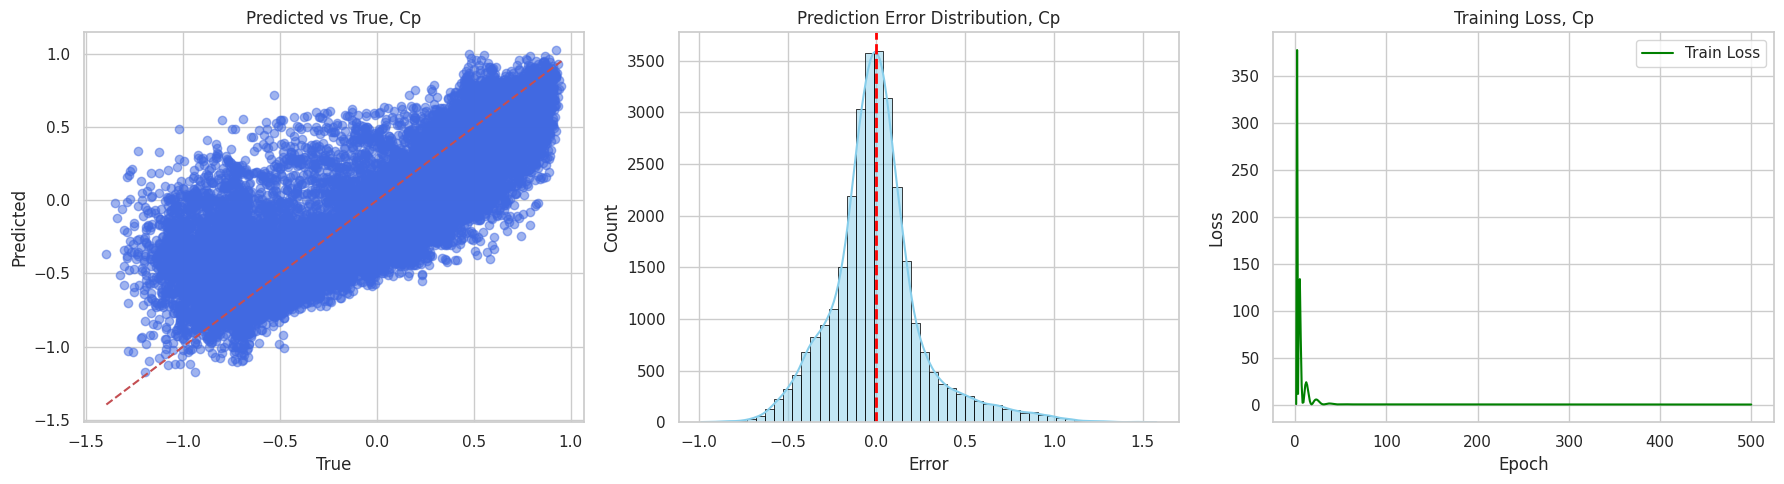

📊 Metric saved: /mnt/d/projects/wind_pressure_prediction_2025/results/figures/mlp_5f_128h_500ep_metrics.png


'/mnt/d/projects/wind_pressure_prediction_2025/results/figures/mlp_5f_128h_500ep_metrics.png'

In [ ]:
# 📁 src/train/train_mlp.py
# ➤ Full training pipeline for MLP model: data loading, training, evaluation, saving results

df = load_dataset()
X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
y = df[['Mean']]
INPUT_DIM = X.shape[1]

HIDDEN_DIM = 128
OUTPUT_DIM = 1
LR = 0.005
EPOCHS = 500
BATCH_SIZE = 64

model_name = f"mlp_{INPUT_DIM}f_{HIDDEN_DIM}h_{EPOCHS}ep"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥 Используемое устройство: {device}")
model = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

log_path = os.path.join(LOG_DIR, f"{model_name}.txt")
with open(log_path, "w") as log_file:
    log_file.write("Epoch\tLoss\n")

    train_indices = set(map(tuple, X_train.cpu().numpy()))
    test_indices = set(map(tuple, X_test.cpu().numpy()))
    intersection = train_indices.intersection(test_indices)
    print(f"Number of matching rows: {len(intersection)}") 

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    train_loss_history = []

    for epoch in tqdm(range(EPOCHS), desc="Epochs"):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss_history.append(loss.item())

        if (epoch + 1) % 10 == 0:
            log_str = f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}"
            print(log_str)
            log_file.write(f"{epoch+1}\t{loss.item():.6f}\n")


weights_path = os.path.join(WEIGHTS_DIR, f"{model_name}.pth")
torch.save(model.state_dict(), weights_path)

config = {
    "input_dim": INPUT_DIM,
    "hidden_dim": HIDDEN_DIM,
    "output_dim": OUTPUT_DIM,
    "lr": LR,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
    "targets": ['Mean']
}
config_path = os.path.join(CONFIG_DIR, f"{model_name}.json")
with open(config_path, "w") as f:
    json.dump(config, f, indent=4)

print(f"✅ Model saved: {weights_path}")
print(f"✅ Configuration saved: {config_path}")

model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    metrics = evaluate_regression(y_test, y_pred)

print("📈 Evaluation metrics on test set:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

metrics_path = os.path.join(METRICS_DIR, f"{model_name}.json")
metrics_clean = {k: float(v) for k, v in metrics.items()}

with open(metrics_path, "w") as f:
    json.dump(metrics_clean, f, indent=4)

plot_metrics(
    y_test,
    y_pred,
    train_loss_history=train_loss_history,
    val_loss_history=[],  
    model_name=model_name,
    show=True 
)
